In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prophet.diagnostics import performance_metrics

from prophet import Prophet
import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
D003_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D003_data.csv')
D003_df
D003_df['time'] =  pd.to_datetime(D003_df['time'], format='%Y-%m-%d %H:%M:%S')
D003_df.rename(columns = {'Rn':'y','time':'ds'}, inplace = True)
D003_df = D003_df.reset_index(drop=True)
D003_df
# D001_df.index = D001_df['time']
# D001_df = D001_df.drop(['time'],axis = 1)
# D001_df.index = D001_df.index.rename('ds')
# D001_df.rename(columns = {'Rn':'y'}, inplace = True)
# D001_columns = list(D001_df.columns)
# D001_columns[0],D001_columns[1] = D001_columns[1],D001_columns[0]
# D001_df = D001_df[D001_columns]

,ds,T,y,H,P,CO2
0,2019-07-09 17:00:00,33.463333,0.100000,38.000000,101.363333,39.666667
1,2019-07-09 18:00:00,33.490000,0.150000,37.666667,101.333800,50.500000
2,2019-07-09 19:00:00,33.180000,0.161667,39.333333,101.331833,50.666667
3,2019-07-09 20:00:00,33.315000,3.451667,40.666667,101.340333,53.833333
4,2019-07-09 21:00:00,32.846667,11.556667,41.333333,101.389333,53.000000
...,...,...,...,...,...,...
20019,2021-12-31 19:00:00,28.650000,956.366667,35.833333,102.174500,43.833333
20020,2021-12-31 20:00:00,28.758000,1275.534000,35.800000,102.192000,41.400000
20021,2021-12-31 21:00:00,28.730000,1321.585000,35.000000,102.246667,40.833333
20022,2021-12-31 22:00:00,28.530000,1163.278333,34.666667,102.356667,40.166667


In [7]:
D003_df

,ds,T,y,H,P,CO2
0,2019-07-09 17:00:00,33.463333,0.100000,38.000000,101.363333,39.666667
1,2019-07-09 18:00:00,33.490000,0.150000,37.666667,101.333800,50.500000
2,2019-07-09 19:00:00,33.180000,0.161667,39.333333,101.331833,50.666667
3,2019-07-09 20:00:00,33.315000,3.451667,40.666667,101.340333,53.833333
4,2019-07-09 21:00:00,32.846667,11.556667,41.333333,101.389333,53.000000
...,...,...,...,...,...,...
20019,2021-12-31 19:00:00,28.650000,956.366667,35.833333,102.174500,43.833333
20020,2021-12-31 20:00:00,28.758000,1275.534000,35.800000,102.192000,41.400000
20021,2021-12-31 21:00:00,28.730000,1321.585000,35.000000,102.246667,40.833333
20022,2021-12-31 22:00:00,28.530000,1163.278333,34.666667,102.356667,40.166667


In [8]:
training_data = D003_df.sample(frac=0.8, random_state=25)
testing_data = D003_df.drop(training_data.index)
testing_data = testing_data.reset_index(drop=True)

testing_data_v2 = testing_data[['ds','T','H','P','CO2']]
testing_data_v2 = testing_data.reset_index(drop=True)


print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 16019
No. of testing examples: 4005


In [9]:
testing_data_v2

,ds,T,y,H,P,CO2
0,2019-07-10 00:00:00,32.245000,8.996667,42.833333,101.358500,42.000000
1,2019-07-10 07:00:00,32.528333,23.056667,40.833333,101.349000,50.500000
2,2019-07-11 01:00:00,34.578333,14.733333,35.333333,101.245500,43.500000
3,2019-07-11 04:00:00,34.700000,2.033333,36.333333,101.195500,55.333333
4,2019-07-11 08:00:00,35.316667,13.008333,35.166667,101.274167,49.833333
...,...,...,...,...,...,...
4000,2021-12-31 08:00:00,26.996667,653.680000,30.333333,102.191667,32.500000
4001,2021-12-31 10:00:00,25.378333,326.585000,34.500000,102.247667,39.000000
4002,2021-12-31 14:00:00,29.036000,377.320000,35.600000,101.905400,51.000000
4003,2021-12-31 18:00:00,28.696667,725.073333,36.166667,101.974167,45.833333


In [10]:
model = Prophet()
model.add_regressor('T',standardize = False)
model.add_regressor('H',standardize = False)
model.add_regressor('P',standardize = False)
model.add_regressor('CO2',standardize = False)

In [11]:
model.fit(training_data)

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [12]:
forecast = model.predict(testing_data_v2)
forecast = forecast[['ds','yhat']]

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [13]:
testing_data

,ds,T,y,H,P,CO2
0,2019-07-10 00:00:00,32.245000,8.996667,42.833333,101.358500,42.000000
1,2019-07-10 07:00:00,32.528333,23.056667,40.833333,101.349000,50.500000
2,2019-07-11 01:00:00,34.578333,14.733333,35.333333,101.245500,43.500000
3,2019-07-11 04:00:00,34.700000,2.033333,36.333333,101.195500,55.333333
4,2019-07-11 08:00:00,35.316667,13.008333,35.166667,101.274167,49.833333
...,...,...,...,...,...,...
4000,2021-12-31 08:00:00,26.996667,653.680000,30.333333,102.191667,32.500000
4001,2021-12-31 10:00:00,25.378333,326.585000,34.500000,102.247667,39.000000
4002,2021-12-31 14:00:00,29.036000,377.320000,35.600000,101.905400,51.000000
4003,2021-12-31 18:00:00,28.696667,725.073333,36.166667,101.974167,45.833333


In [14]:
forecast

,ds,yhat
0,2019-07-10 00:00:00,395.222333
1,2019-07-10 07:00:00,367.829678
2,2019-07-11 01:00:00,403.319573
3,2019-07-11 04:00:00,383.414534
4,2019-07-11 08:00:00,386.056989
...,...,...
4000,2021-12-31 08:00:00,702.803434
4001,2021-12-31 10:00:00,575.066628
4002,2021-12-31 14:00:00,593.578107
4003,2021-12-31 18:00:00,633.603659


In [15]:
comparation_df = pd.concat((pd.DataFrame(forecast['yhat']),testing_data),axis = 1)

In [16]:
comparation_df 

,yhat,ds,T,y,H,P,CO2
0,395.222333,2019-07-10 00:00:00,32.245000,8.996667,42.833333,101.358500,42.000000
1,367.829678,2019-07-10 07:00:00,32.528333,23.056667,40.833333,101.349000,50.500000
2,403.319573,2019-07-11 01:00:00,34.578333,14.733333,35.333333,101.245500,43.500000
3,383.414534,2019-07-11 04:00:00,34.700000,2.033333,36.333333,101.195500,55.333333
4,386.056989,2019-07-11 08:00:00,35.316667,13.008333,35.166667,101.274167,49.833333
...,...,...,...,...,...,...,...
4000,702.803434,2021-12-31 08:00:00,26.996667,653.680000,30.333333,102.191667,32.500000
4001,575.066628,2021-12-31 10:00:00,25.378333,326.585000,34.500000,102.247667,39.000000
4002,593.578107,2021-12-31 14:00:00,29.036000,377.320000,35.600000,101.905400,51.000000
4003,633.603659,2021-12-31 18:00:00,28.696667,725.073333,36.166667,101.974167,45.833333


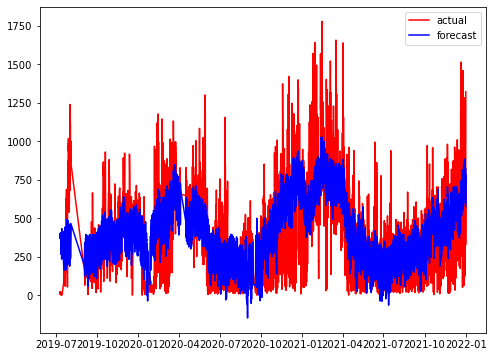

In [17]:
plt.figure(figsize=(8,6))
plt.plot(comparation_df['ds'],comparation_df['y'],color = 'red',label = 'actual')
plt.plot(comparation_df['ds'],comparation_df['yhat'],color = 'blue',label = 'forecast')
plt.legend()